In [2]:
import os 
import re
import random
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from Bio import SeqIO
from itertools import islice
from tqdm import tqdm
import torch

import tensorflow as tf

from keras.utils.np_utils import to_categorical
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, GRU
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

# Preprocessing

## Embedding generation

### Core PU Sequence generation

In [2]:
classes = []
topo = []
protofold = []
fq = []
pu = []

with open('database/LISTS_CATFS_PU_PROTOTYPE_with_fused_famillies', 'r') as file:
    for line in islice(file, 7, None):
        tmp = line.split(maxsplit=5)
        if len(tmp[2])>=2 and int(tmp[4])>10:
            classes.append(tmp[0])
            topo.append(tmp[2])
            protofold.append(tmp[3])
            fq.append(tmp[4])
            pu.append(tmp[5])

x = {'Class':classes, 'Topology':topo, 'Protofold':protofold, 'Frequency':fq, 'PU':pu}
list_pu = pd.DataFrame(x, columns=['Class', 'Topology', 'Protofold', 'Frequency', 'PU'])
list_pu = list_pu.astype({'Frequency': 'int'})

In [3]:
list_pu

,Class,Topology,Protofold,Frequency,PU
0,Alpha-beta,aUbLa,35.g162,157,1YISA_10_258_288 :3K7XA_10_267_294 4G10A_4_105...
1,Alpha-beta,bUaUbLa,45.g94,31,3ICSA_11_510_555 :2HHGA_2_86_132 3SNKA_1_1_48 ...
2,All-alpha,aUa,30.g155,18,1GTVA_5_94_120 :3HHWK_10_221_247 3CYMA_11_344_...
3,Alpha-beta,aLbUa,40.g195,30,2YGUA_1_1_44 :2QUYA_2_220_260 3NRGA_4_65_113 3...
4,All-beta,bUbUb,40.g161,12,3HBKA_4_141_178 :3HBKA_4_141_178 2V73A_2_96_13...
...,...,...,...,...,...
1170,Alpha-beta,aUb,20.g33,209,2OCZA_4_73_96 :3I4JA_10_62_87 3MDDA_10_66_89 2...
1171,Alpha-beta,aUbLa,30.g84,37,1EV7A_6_179_211 :3SQNA_10_282_316 2ICWG_3_151_...
1172,All-beta,bUbUb,30.g13,91,1EW4A_3_26_53 :3Q7MA_10_123_156 3OBYA_10_110_1...
1173,Alpha-beta,aLbLa,30.g11,200,1OKSA_1_1_30 :3LLKA_5_136_165 3FRKA_10_339_365...


Sort Dataframe by Frequency and
Remove duplicate for Protofold

In [4]:
list_pu = list_pu.sort_values('Frequency', ascending=False)
filt_pu = list_pu.drop_duplicates(subset=['Topology', 'Protofold','Frequency'], keep='first')
filt_pu = filt_pu.reset_index(drop=True)

In [6]:
filt_pu

,Class,Topology,Protofold,Frequency,PU
0,Alpha-beta,bLa,35.g219,1209,1VHOA_7_288_318 :3VHLA_6_236_264 3ONOA_1_142_1...
1,All-alpha,aUa,30.g9,1004,1S9UA_4_157_189 :2RKLA_1_17_53 3G7RA_3_152_182...
2,All-alpha,aUa,35.g0,1004,1CPQA_3_16_49 :3M73A_10_84_118 3PEVB_6_89_128 ...
3,All-alpha,aUa,30.g28,966,1IO1A_5_30_63 :1ZROA_13_488_520 2QX5A_10_353_3...
4,All-alpha,aUa,40.g122,903,2PZIA_10_505_544 :3NCTA_3_1_34 3MZVA_1_272_309...
...,...,...,...,...,...
687,All-beta,bUbLb,35.g133,11,1YFQA_10_270_301 :3F3FA_10_32_63 3VU4A_12_21_5...
688,Alpha-beta,aUbUb,40.g87,11,1C7NA_6_290_331 :2CY8A_10_284_325 3BCHA_2_156_...
689,Alpha-beta,aUbLa,25.g204,11,1KHDA_10_1_25 :2WB7A_10_132_158 2NSZA_3_105_12...
690,Alpha-beta,bUa,30.g156,11,1MOQA_11_51_78 :3SDOA_12_320_347 2AMLA_11_217_...


Generate list of pu without redundancy of pu in a protofold class (for example, 30.g219 and 50.g219 are considered the same so if a pu is present in both class, only the first one will be kept)


In [19]:
df_pu = pd.DataFrame().assign(Protofold = filt_pu.iloc[:300,:]['Protofold'], PU = filt_pu.iloc[:300,:]['PU'])
tmp_df = df_pu['PU'].str.split(' ').apply(pd.Series, 1).stack() #Split PU into rows
tmp_df = tmp_df.replace(r'n','', regex=True).replace(r':','', regex=True) #Remove 'n' and ':'
tmp_df.index = tmp_df.index.droplevel(-1)
tmp_df.name = 'PU' #Need to rename to have index with which joining can be done
del df_pu['PU']
df_pu = df_pu.join(tmp_df)
df_pu['Class'] = df_pu['Protofold'].str.split('.', expand = True)[1] #Get ID : 35.g129 -> g219
df_pu = df_pu.drop_duplicates(subset=['PU', 'Class'], keep='first')
df_pu

,Protofold,PU,Class
0,35.g219,1VHOA_7_288_318,g219
0,35.g219,3VHLA_6_236_264,g219
0,35.g219,3ONOA_1_142_167,g219
0,35.g219,3U52A_5_51_82,g219
0,35.g219,3T92A_1_86_112,g219
...,...,...,...
299,20.g92,3M0ZA_7_179_194,g92
299,20.g92,2VHJA_10_207_222,g92
299,20.g92,3ROTA_11_150_165,g92
299,20.g92,1W94A_5_19_34,g92


In [6]:
select_pu, unique_pu = [], []
select_pu = df_pu[['Protofold', 'PU']].values.tolist()
[unique_pu.append([proto, pu]) for proto, pu in select_pu if pu not in [item[1] for item in unique_pu]]
print(f"There are {len(select_pu)} total PU and {len(unique_pu)} unique")

There are 45100 total PU and 18765 unique


### Generate Core PU Embedding with ESMFold2

Generate PU for aligning and getting source sequence. Embedding will be done on unique_pu first as some of their source sequences are shared with select_pu

In [ ]:
def pdb_gen(file):
    with open(tmp.txt) as file:
      f = file.read()
      pdb = re.search(r">>\w{4}_.", f).group(0)[2:]
      pos = re.findall(r"\d+-\d+", f)[1]
      yield pdb, pos

In [ ]:
no_result = []

for proto, pu in tqdm(islice(unique_pu, len(unique_pu))):
  name = f'{pu[0:4].lower()}_{pu[4]}'
  !ssearch36 ./PU/$pu.fasta ./pdb_seqres.txt | grep -A2 -m1 ^>>$name > ./tmp.txt
  
  if os.stat(tmp.txt).st_size != 0: #If file not empty = If alignment gives result
    for y in pdb_gen(tmp.txt):
      pdb, pos = y
      !grep -A1 $pdb ./pdb_seqres.txt | sed s/>{pdb}/&_{proto}_{pos}/ >> pdb_core.fasta
  else:
    no_result.append([proto, pu])

In [ ]:
with open('tmp.fasta', 'w') as f:
    records = SeqIO.parse('./pdb_core.fasta', 'fasta')
    for record in records:
        f.write(f'>{record.id}n')
        f.write(f'{record.seq}n')
!esm-extract esm2_t33_650M_UR50D tmp.fasta ./emb_esm2/ --include per_tok

List of PU without embedding, including those in select_pu

In [ ]:
list_emb = os.listdir("emb_esm2/") 

In [ ]:
l = []
for proto, pu in select_pu:
    l.append([pu, proto, f'{pu[:4].lower()}_{pu[4]}_{proto}']) # Formatting name the same as embedding file name

l_emb = []
for emb in list_emb: 
    x = emb.split('_') # Example file name : 1a0c_A_25.g86_66-94.pt
    l_emb.append(f'{x[0]}_{x[1]}_{x[2]}')

no_emb = []
[no_emb.append([pu, p, x]) for pu, p, x in l if x not in l_emb]

## Data generation

In [ ]:
def pad(array, target_shape):
    return np.pad(array, [(0, target_shape[i] - array.shape[i]) for i in range(len(array.shape))], "constant")

def data_gen(path_file, path_save, name, pos_start, pos_end):
    tmp = torch.load(path_file)
    tens = np.array(tmp["representations"][33])[pos_start:pos_end]

    try:
        tens_padded = pad(tens, (60, 1280))
    except ValueError:
        tens_padded = np.resize(tens, (60, 1280))
    
    if not os.path.exists(path_save):
        os.makedirs(path_save)
        np.savetxt(f'{path_save}/{name}.csv', tens_padded, delimiter = ",")
    else:
        np.savetxt(f'{path_save}/{name}.csv', tens_padded, delimiter = ",")

### PU cores

Select sequence of interest from embedding for PUs unique

In [ ]:
for file in tqdm(list_emb):
    name = f"{os.path.basename(file).split('_')[0]}_{os.path.basename(file).split('_')[1]}"
    pu_class = os.path.basename(file).split('_')[2]
    pos_start = int(file.split('_')[-1].split("-")[0])-1
    pos_end = int(file.split('_')[-1].split('-')[-1].rsplit(".")[0])

    path_save = f"dataset/{pu_class}"
    path_file = f"emb_esm2/{file}"
    
    if os.path.isfile(f"{path_save}/{name}.csv"):
        pass
    else:
        data_gen(path_file, path_save, name, pos_start, pos_end)

### Noncores PU

For Noncore PUs
- Directly generate padded data from embedded source sequences used for core PUs
- If PU don't have their source sequences embedded, we generate them 
- Generate data for those PU

1) Generate list of noncores PU

In [30]:
nc_list_file = []
nc_names = []
nc_length = []
nc_pos_start = []
nc_pos_end = []
with open('database/LIST_OF_PUs_UNCLASSED.txt', 'r') as file:
    for line in file: #Ex : 16VPA_10_41_59.fasta
        tmp = line.rstrip().split('_')[0]
        nc_names.append(f"{tmp[:-1].lower()}_{tmp[-1]}")
        nc_length.append(line.split('_')[1])
        nc_pos_start.append(int(line.rstrip().split('_')[-2]))
        nc_pos_end.append(int(line.rstrip().split('_')[-1].split('.')[0]))
        nc_list_file.append(line.rstrip().split('.')[0])

In [31]:
x = {"Filename" : nc_names, 'Length' : nc_length, "Start" : nc_pos_start,"End" : nc_pos_end}
df_nc = pd.DataFrame(x, columns=["Filename", "Length", "Start", "End"])
df_nc = df_nc.astype({'Length': 'int'})

df_nc = df_nc.sort_values('Length', ascending=False)
df_modif_nc = df_nc.drop_duplicates(subset=["Filename", "Length", "Start", "End"], keep='first')
df_modif_nc = df_modif_nc[df_modif_nc['Length'] >= 10]
df_modif_nc = df_modif_nc.reset_index(drop=True)
df_modif_nc

,Filename,Length,Start,End
0,2x6w_A,27,175,199
1,2x6w_A,27,200,218
2,1kmo_A,27,105,122
3,1k3i_A,26,383,401
4,1k3i_A,26,402,422
...,...,...,...,...
44141,2hbv_A,10,1,22
44142,2hbj_A,10,272,293
44143,2g82_A,10,53,71
44144,2g82_A,10,72,91


In [ ]:
nc_data = df_modif_nc.replace(r'_','', regex=True).astype(str).values.tolist()
nc_data = ['_'.join(sublist).upper() for sublist in nc_data]

2) Generate padded data for those with source sequences embedded

In [ ]:
nc_no_emb = []
for filename in tqdm(nc_data):
    name = filename.split('_')[0][:-1].lower() # To match embedding file name : 2X6WA_27_175_199 in nc_data -> 2x6w* in embedding file
    for file in glob.glob(f'emb_esm2/{name}*'):
        save = "dataset/noncore/"
        nc_start = int(filename.split('_')[-2])
        nc_end = int(filename.split('_')[-1])
        data_gen(file, save, filename, nc_start, nc_end)
    tmp = f"{save}/{filename}.csv"
    if os.path.isfile(tmp):
        pass
    else:
        nc_no_emb.append(filename)

3) From list of PU without source sequences embedding, generate embedding with ESM-extract

In [ ]:
extra = []
tmp = [x for x in [f"{items[:4].lower()}_{items[4]}" for items in nc_no_emb] if x not in extra]
extra = list(set(tmp))
print(len(extra))

In [ ]:
with open('tmp.fasta', 'w+') as f:
    for element in tqdm(extra):    
        records = SeqIO.parse('database/pdb_seqres.txt', 'fasta')
        for record in records:
            if element in record.id:
                f.write(f'>{record.id}n')
                f.write(f'{record.seq}n')
!esm-extract esm2_t33_650M_UR50D tmp.fasta ./emb_nc_extra/ --include per_tok

Some PU don't have their source sequence in the database. In this case, we won't be using PUs associated to these sequences.

In [ ]:
l = os.listdir("./emb_nc_extra/")
nc_emb_miss = [file for file in extra if not any(file in emb for emb in l)]
len(nc_emb_miss)

4) Finally, generate padded for PU left over

In [ ]:
for filename in tqdm(nc_no_emb): #List of PU without embedding generated previously
    name = filename.split('_')[0][:-1].lower() # To match embedding file name : 2X6WA_27_175_199 in nc_data -> 2x6w* in embedding file
    for file in glob.glob(f'emb_nc_extra/{name}*'):
        save = "dataset/noncore/"
        nc_start = int(filename.split('_')[-2])
        nc_end = int(filename.split('_')[-1])
        data_gen(file, save, filename, nc_start, nc_end)

# Dataset preparation

## List preparation

In [4]:
def split_data(split_coeff, data_list, train_data, test_data, val_data):
    data_split = int((len(data_list))*split_coeff)
    test_data += data_list[data_split:]

    tmp_train_data = data_list[:data_split] # 80% of initial data
    train_split = int(len(tmp_train_data)*split_coeff)

    train_data += tmp_train_data[:train_split]
    val_data += tmp_train_data[train_split:]
    return train_data, test_data, val_data

Select 80% of data of each PU protofold for training and remaining 20% for test, and further split the initial 80% of training data into 80/20 for training and validation. The overall percentage of initial data will be :
- 64% for training
- 20% for testing
- 16% for validation

In [4]:
data_count = {}
train_data, test_data, val_data = [], [], []
path = 'dataset/'
core_list = os.listdir(path)
split_coeff = .8
for core in core_list:
    data_list = [f"dataset/{core}/{data}" for data in os.listdir(os.path.join(path, core))]
    random.shuffle(data_list)
    split_data(split_coeff, data_list, train_data, test_data, val_data)
    data_count[core] = len(data_list)

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/'

### Details on data generated

In [15]:
print(f"After splitting data between train/test dataset :\nTrain dataset contains {len(train_data)} PUs\nTest dataset contains {len(test_data)} PUs\nVal dataset contains {len(val_data)} PUs")

After splitting data between train/test dataset :
Train dataset contains 51359 PUs
Test dataset contains 16229 PUs
Val dataset contains 12978 PUs


In [16]:
a = len(train_data) + len(test_data) + len(val_data)
print(f"Total is {a} PUs")
print(f"Train percentage = {round(len(train_data)*100/a)}% of total PUs")
print(f"Test percentage = {round(len(test_data)*100/a)}% of total PUs")
print(f"Val percentage = {round(len(val_data)*100/a)}% of total PUs")

Total is 80566 PUs
Train percentage = 64% of total PUs
Test percentage = 20% of total PUs
Val percentage = 16% of total PUs


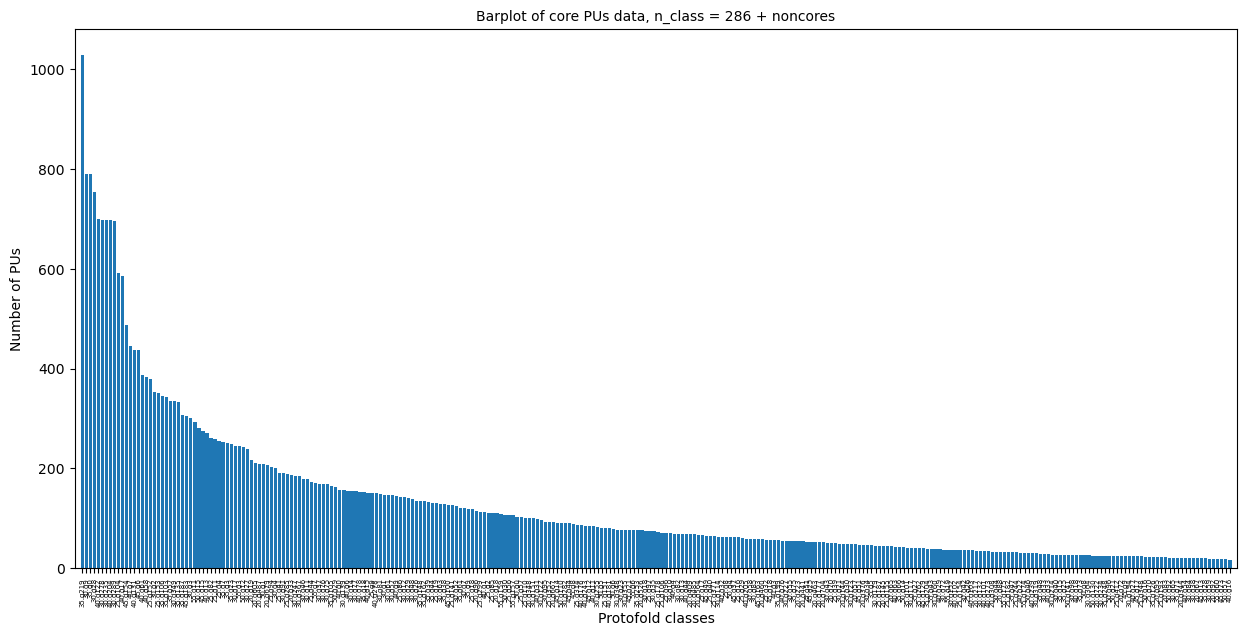

In [20]:
pu = [key for key, _ in sorted(data_count.items(), key=lambda x: x[1], reverse=True) if key != 'noncore']
value = [value for key, value in sorted(data_count.items(), key=lambda x: x[1], reverse=True) if key != 'noncore']

plt.figure(figsize=(15,7))
plt.bar(range(len(data_count)-1), value, tick_label = pu)
plt.margins(x=0.005)
plt.yticks(size = 10)
plt.xticks(size = 5, rotation = 90)
plt.xlabel("Protofold classes", size = 10)
plt.ylabel("Number of PUs", size = 10)
plt.title(f"Barplot of core PUs data, n_class = {len(data_count.keys())-1} + noncores", size = 10)
plt.show()

### Adjust weight

Adjust class weight base of classification used :

In [17]:
sorted(data_count.items(), key=lambda x: x[1], reverse=True)

[('noncore', 43886),
 ('35.g219', 1029),
 ('30.g9', 791),
 ('35.g0', 791),
 ('30.g28', 755),
 ('40.g122', 701),
 ('30.g278', 699),
 ('30.g235', 699),
 ('40.g204', 699),
 ('30.g289', 697),
 ('25.g104', 592),
 ('40.g17', 586),
 ('45.g154', 488),
 ('40.g7', 445),
 ('40.g131', 438),
 ('45.g6', 438),
 ('40.g61', 388),
 ('40.g58', 383),
 ('25.g152', 379),
 ('30.g2', 353),
 ('25.g153', 351),
 ('35.g106', 345),
 ('35.g103', 344),
 ('35.g57', 336),
 ('30.g349', 335),
 ('35.g135', 333),
 ('35.g187', 308),
 ('45.g183', 306),
 ('30.g3', 301),
 ('55.g11', 294),
 ('50.g15', 281),
 ('45.g15', 275),
 ('40.g13', 271),
 ('25.g82', 261),
 ('25.g11', 260),
 ('25.g4', 256),
 ('35.g7', 254),
 ('35.g3', 252),
 ('35.g23', 250),
 ('30.g17', 245),
 ('55.g3', 244),
 ('50.g12', 242),
 ('30.g27', 239),
 ('20.g19', 216),
 ('20.g605', 210),
 ('20.g487', 209),
 ('50.g1', 208),
 ('20.g679', 206),
 ('25.g94', 203),
 ('30.g4', 201),
 ('25.g41', 191),
 ('30.g91', 190),
 ('25.g285', 188),
 ('20.g33', 187),
 ('30.g247', 18

Class with highest number of samples except for non core is '35.g219'. This class will then be compared to order class and its weight will be adjusted according to length of dataset. For this classification, "noncore" will not be used because of the high number of samples in its class

Weight of class noncore is : 1.17
Weight of other class is : 1.4


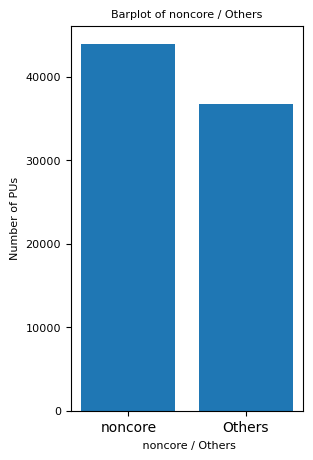

In [18]:
# For binary classification, we specify the class to compare

class_classif = 'noncore'
weight_classif = round(len(train_data)/data_count[class_classif], 2)
sum_nonclassif = sum(value for key, value in data_count.items() if key != class_classif)
weight_nonclassif = round(len(train_data)/sum_nonclassif, 2)
class_weights = {0 : weight_nonclassif, 1 : weight_classif}
print(f"Weight of class {class_classif} is : {weight_classif}\nWeight of other class is : {weight_nonclassif}")

binary_key = [class_classif, 'Others']
binary_value = [data_count[class_classif], sum_nonclassif]

plt.figure(figsize=(3, 5))
plt.bar(binary_key, binary_value, tick_label = binary_key)
plt.yticks(size = 8)
plt.xlabel(f" {class_classif} / Others", size = 8)
plt.ylabel("Number of PUs", size = 8)
plt.title(f"Barplot of {class_classif} / Others", size = 8)
plt.show()

## Adjusted data (50 highest sample number)

In [ ]:
trim_data = dict(islice(sorted(data_count.items(), key=lambda x: x[1], reverse=True), 300))

Copy of selected data in a new directory to avoid confusion (Run once only)

In [ ]:
import shutil

for core in trim_data.keys():
    if core == "noncore":
        if not os.path.exists(f"dataset_trim/noncore"):
            os.makedirs(f"dataset_trim/noncore")
        list_path = [f"noncore/{data}" for data in os.listdir(nc_path)]
        random.shuffle(list_path)
        for element in tqdm(list_path[:12000]):
            path_source = f"dataset/{element}"
            path_target = f"dataset_trim/{element}"
            shutil.copy(path_source, path_target)
            
    else:
        list_path = os.listdir(f"dataset/{core}")
        for element in list_path:
            path_source = f"dataset/{core}/{element}"
            path_target = f"dataset_trim/{core}/{element}"
    
            if not os.path.exists(f"dataset_trim/{core}"):
                os.makedirs(f"dataset_trim/{core}")
            
            shutil.copy(path_source, path_target)   

After the code above is run, we can skip to the below and generate datasets

In [5]:
trim_data = {}
train_data, test_data, val_data = [], [], []
path = 'dataset_trim/'
core_list = os.listdir(path)
split_coeff = .8
for core in core_list:
    trim_list = [f"dataset_trim/{core}/{data}" for data in os.listdir(os.path.join(path, core))]
    random.shuffle(trim_list)
    split_data(split_coeff, trim_list, train_data, test_data, val_data)
    trim_data[core] = len(trim_list)

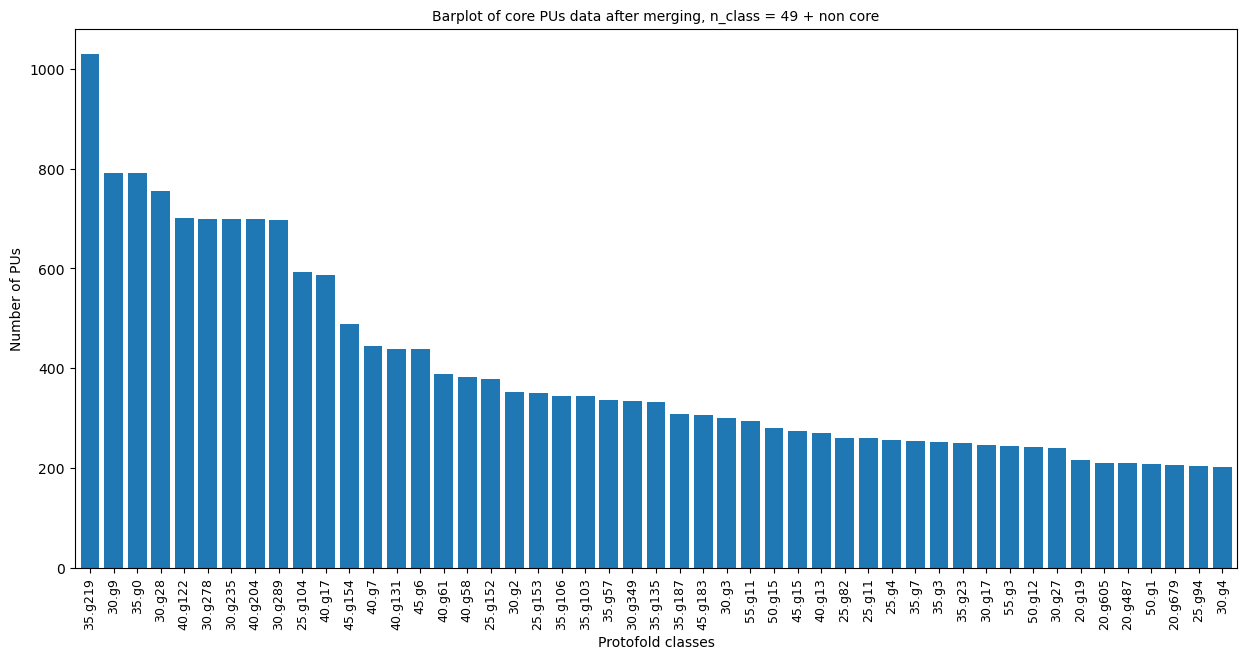

In [6]:
pu = [key for key, _ in sorted(trim_data.items(), key=lambda x: x[1], reverse=True) if key != 'noncore']
value = [value for key, value in sorted(trim_data.items(), key=lambda x: x[1], reverse=True) if key != 'noncore']

plt.figure(figsize=(15,7))
plt.bar(range(len(trim_data)-1), value, tick_label = pu)
plt.margins(x=0.005)
plt.yticks(size = 10)
plt.xlabel("Protofold classes", size = 10)
plt.xticks(size = 9, rotation = 90)
plt.ylabel("Number of PUs", size = 10)
plt.title(f"Barplot of core PUs data after merging, n_class = {len(trim_data.keys())-1} + non core", size = 10)
plt.show()

In [6]:
a = len(train_data) + len(test_data) + len(val_data)
print(f"After splitting data between train/test dataset :")
print(f"Train dataset contains {len(train_data)} PUs, {round(len(train_data)*100/a)}% of total PUs")
print(f"Test dataset contains {len(test_data)} PUs, {round(len(test_data)*100/a)}% of total PUs")
print(f"Val dataset contains {len(val_data)} PUs, {round(len(val_data)*100/a)}% of total PUs")

After splitting data between train/test dataset :
Train dataset contains 20053 PUs, 64% of total PUs
Test dataset contains 6298 PUs, 20% of total PUs
Val dataset contains 5036 PUs, 16% of total PUs


For a binary classification, we give weight according to total number of data in the training dataset

Weight of class noncore is : 1.67
Weight of other class is : 1.03


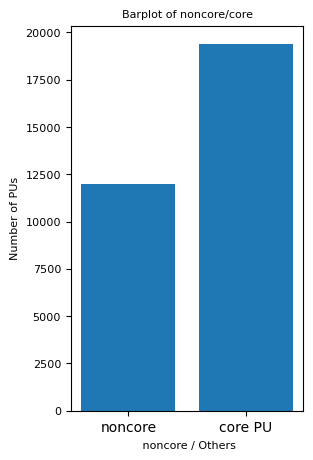

In [8]:
class_classif = 'noncore'
weight_classif = round(len(train_data)/trim_data[class_classif], 2)
sum_nonclassif = sum(value for key, value in trim_data.items() if key != "noncore")
weight_nonclassif = round(len(train_data)/sum_nonclassif, 2)
class_weights = {0 : weight_nonclassif, 1 : weight_classif}
print(f"Weight of class {class_classif} is : {weight_classif}\nWeight of other class is : {weight_nonclassif}")

binary_key = [class_classif, 'core PU']
binary_value = [trim_data[class_classif], sum_nonclassif]

plt.figure(figsize=(3, 5))
plt.bar(binary_key, binary_value, tick_label = binary_key)
plt.yticks(size = 8)
plt.xlabel(f" {class_classif} / Others", size = 8)
plt.ylabel("Number of PUs", size = 8)
plt.title(f"Barplot of noncore/core", size = 8)
plt.show()

For a categorical classification, weight will be given according to the highest number of samples, to avoid too high weight values. With this dataset, highest number of samples is in the "noncore" class

In [13]:
# Encoding label for categorical classification at the same time as setting class weights

class_encoding = {}
class_weights_cat = {}
for i, (key, value) in enumerate(trim_data.items()):
    class_encoding[key] = i
    class_weights_cat[i] = round(12000/value, 2)

# Network application

For data : 
- data_count.keys() containing all protofold classes
- train_data and test_data containing list of files for the generator

In [8]:
def data_generator(files, batch_size, num_classes, method, class_classification = None):
    n_files = len(files)
    
    while True:
        np.random.shuffle(files)
        for i in range(0, n_files - batch_size + 1, batch_size):
            batch_files = files[i:i+batch_size]
            batch_data = []
            batch_labels = []
            for file in batch_files:
                data = pd.read_csv(file, header=None).values
                label = file.split('/')[-2]
                if method == "binary" or method is None:
                    if label == class_classification or label is None:
                        batch_labels.append(0)
                        batch_data.append(data)
                    else:
                        batch_labels.append(1)
                        batch_data.append(data)
                elif method == "categorical":
                    batch_labels.append(class_encoding[label])
                    batch_data.append(data)
                           
            batch_data = np.array(batch_data)
            if method == "binary":
                batch_labels = np.array(batch_labels)
            else:
                batch_labels = np.array(batch_labels)
                batch_labels = to_categorical(batch_labels, num_classes)

            yield batch_data, batch_labels

In [8]:
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience = 3,
    mode = 'min',
    verbose = 1)

## Binary

We will try a binary classification first. Below is the code for this classification but it is adapted to be an executable file to be run in the iPOP-UP plateform of the university

In [31]:
#For binary classification

batch_size = 4
num_classes = 2
class_classif = "noncore"
random.shuffle(train_data)
random.shuffle(val_data)
random.shuffle(test_data)
train_bin_generator = data_generator(train_data, batch_size, num_classes, method = "binary", class_classification = class_classif)
val_bin_generator = data_generator(val_data, batch_size, num_classes, method = "binary", class_classification = class_classif)

In [27]:
def gru_binary(learn_rate):
    model = Sequential()
    model.add(GRU(64, input_shape=(60, 1280), return_sequences=True))
    model.add(GRU(64))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learn_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


learn_rate = 1e-4
model = gru_binary(learn_rate)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 60, 64)            258432    
                                                                 
 gru_3 (GRU)                 (None, 64)                24960     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 283,457
Trainable params: 283,457
Non-trainable params: 0
_________________________________________________________________


2023-06-03 20:17:32.589803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-03 20:17:32.590696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-03 20:17:32.592326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

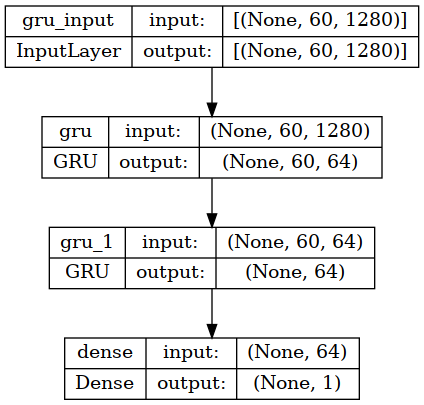

In [3]:
plot_model(model, to_file="model_gru_binary.png",
    show_shapes=True, show_layer_names=True)

In [ ]:
train_bin_steps = len(train_data) // batch_size
val_bin_steps = len(val_data) // batch_size

output_file = f"save/bin_adjusted_batch{batch_size}_lr{str(learn_rate).split('e')[-1]}.csv"
csv_logger = tf.keras.callbacks.CSVLogger(output_file)

hist_model = model.fit(
    train_bin_generator, 
    validation_data = val_bin_generator, 
    steps_per_epoch = train_bin_steps, 
    validation_steps = val_bin_steps, 
    epochs = 15, 
    class_weight = class_weights,
    callbacks = [early_stopping_callback, csv_logger]
    )

Until now, the code was part of the executable mentioned above. That's why, we will load the model generated here :

In [ ]:
bin_model = load_model('binary_adjusted_batch4_lr-05.h5')

In [19]:
batch_size = 64
test_bin_generator = data_generator(test_data, batch_size, num_classes, method = "binary", class_classification = class_classif)
test_bin_steps = len(test_data) // batch_size

hist = bin_model.evaluate(test_bin_generator, steps = test_bin_steps)

2023-06-03 20:31:19.862155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


98/98 [==============================] - 338s 3s/step - loss: 0.1227 - accuracy: 0.9668


In [13]:
pred_labels = []
true_labels = []

batch_size = 128
num_classes = 2
class_classif = "noncore"
test_bin_steps = len(test_data) // batch_size
test_bin_generator = data_generator(test_data, batch_size, num_classes, method = "binary", class_classification = class_classif)

In [ ]:
ytest, ypred = [], []

for data, label in test_bin_generator:
    if len(ytest) < len(test_data):
        ytmp = bin_model.predict(data)
        ypred.extend(ytmp[0])
        ytest.extend(label)
    else:
        break

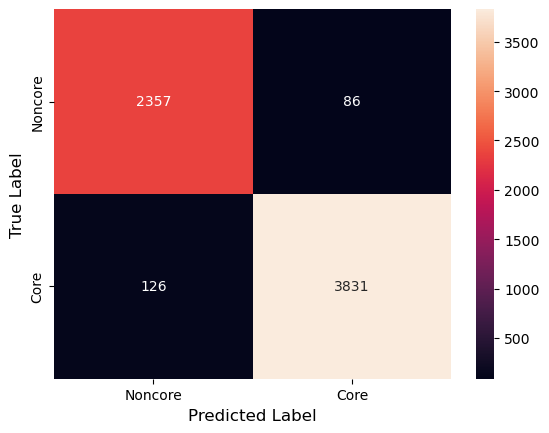

In [72]:
pred_labels = np.where(ypred>0.5, 1, 0)
cm = confusion_matrix(ytest, pred_labels)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, fmt = 'g', xticklabels = ["Noncore", "Core"], yticklabels = ["Noncore", "Core"])
plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [69]:
print(classification_report(ytest, pred_labels, target_names=["Noncore", "Core"]))

              precision    recall  f1-score   support

     Noncore       0.95      0.96      0.96      2443
        Core       0.98      0.97      0.97      3957

    accuracy                           0.97      6400
   macro avg       0.96      0.97      0.97      6400
weighted avg       0.97      0.97      0.97      6400



## Catego

In [10]:
# For categorical classification

batch_size = 4
num_classes = len(trim_data.keys())

random.shuffle(train_data)
random.shuffle(val_data)
random.shuffle(test_data)
train_cat_generator = data_generator(train_data, batch_size, num_classes, method = "categorical")
val_cat_generator = data_generator(val_data, batch_size, num_classes, method = "categorical")

In [56]:
# binary_model = load_model('binary_adjusted_batch4_lr-05.h5') #If model not yet loaded
learn_rate = 0.001
optimizer = Adam(learning_rate=learn_rate)

denselay = Dense(64)(bin_model.layers[-2].output)
outputlay = Dense(len(trim_data.keys()), activation='softmax')(denselay)
cat_model = Model(bin_model.input, outputlay)

cat_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

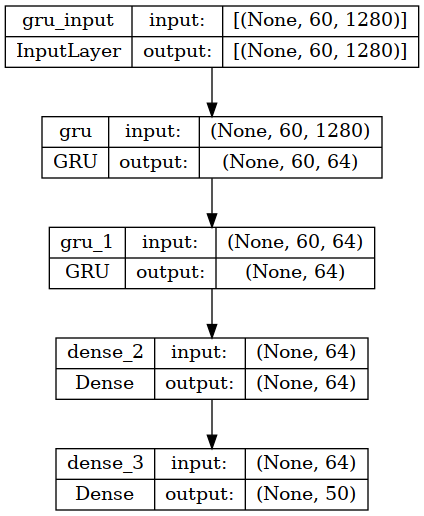

In [58]:
plot_model(cat_model, to_file="model_gru_categorical.png",
    show_shapes=True, show_layer_names=True)

In [ ]:
train_cat_steps = len(train_data) // batch_size
val_cat_steps = len(val_data) // batch_size

output_file = f"save/cat_adjusted_batch{batch_size}_lr{str(learn_rate).split('e')[-1]}.csv"
csv_logger = tf.keras.callbacks.CSVLogger(output_file)

hist_cat = cat_model.fit(train_cat_generator,
    validation_data = val_cat_generator, 
    steps_per_epoch = train_cat_steps, 
    validation_steps = val_cat_steps, 
    epochs = 15, 
    class_weight = class_weights_cat,
    callbacks = [early_stopping_callback, csv_logger]
    )

In [3]:
cat_load_model = load_model("save/categorical_adjusted_batch4_lr0.001.h5")

2023-06-04 15:47:36.751691: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-06-04 15:47:36.928569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-04 15:47:36.929621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-04 15:47:36.9

In [14]:
pred_labels = []
true_labels = []

batch_size = 64
test_cat_generator = data_generator(test_data, batch_size, num_classes, method = "categorical")
test_cat_steps = len(test_data) // batch_size

hist = cat_load_model.evaluate(test_cat_generator, steps = test_cat_steps)

2023-06-04 15:49:09.867334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-04 15:49:09.994197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-04 15:49:09.995059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

98/98 [==============================] - 654s 7s/step - loss: 11.2207 - accuracy: 0.0099


In [19]:
ytest, ypred = [], []

for data, label in test_cat_generator:
    if len(ytest) < len(test_data):
        ytmp = cat_load_model.predict(data)
        ypred.extend(ytmp)
        ytest.extend(label)
    else:
        break

2/2 [==============================] - 13s 6s/step


In [21]:
ypred

[array([1.30729342e-04, 1.48912499e-04, 6.63465107e-05, 7.36482398e-05,
        7.30076194e-01, 2.10120622e-03, 5.89549090e-05, 5.73575307e-05,
        1.23827704e-05, 1.21426936e-04, 6.79165259e-06, 3.43759275e-05,
        1.21470530e-05, 9.36056487e-03, 1.00693913e-04, 2.02193037e-01,
        9.04453336e-05, 9.81862759e-05, 9.53057242e-05, 7.02805060e-04,
        2.11861203e-04, 2.81822082e-04, 9.49262903e-05, 8.62119850e-05,
        1.35049035e-04, 1.91143816e-04, 2.38310713e-02, 4.82010713e-04,
        8.54038881e-05, 3.33639502e-04, 9.91942725e-05, 5.30055317e-04,
        7.27898395e-03, 1.97016983e-04, 2.18622772e-05, 1.27118605e-04,
        4.34315851e-04, 7.32535191e-05, 8.50709257e-05, 4.23650665e-04,
        2.45520641e-04, 1.11397974e-04, 4.65593075e-05, 1.53154688e-04,
        7.78918984e-05, 7.05091634e-06, 1.47948100e-04, 6.82945480e-04,
        1.73895694e-02, 5.92850382e-04], dtype=float32),
 array([1.11009225e-01, 1.10055448e-03, 2.03205069e-04, 5.85776579e-04,
       

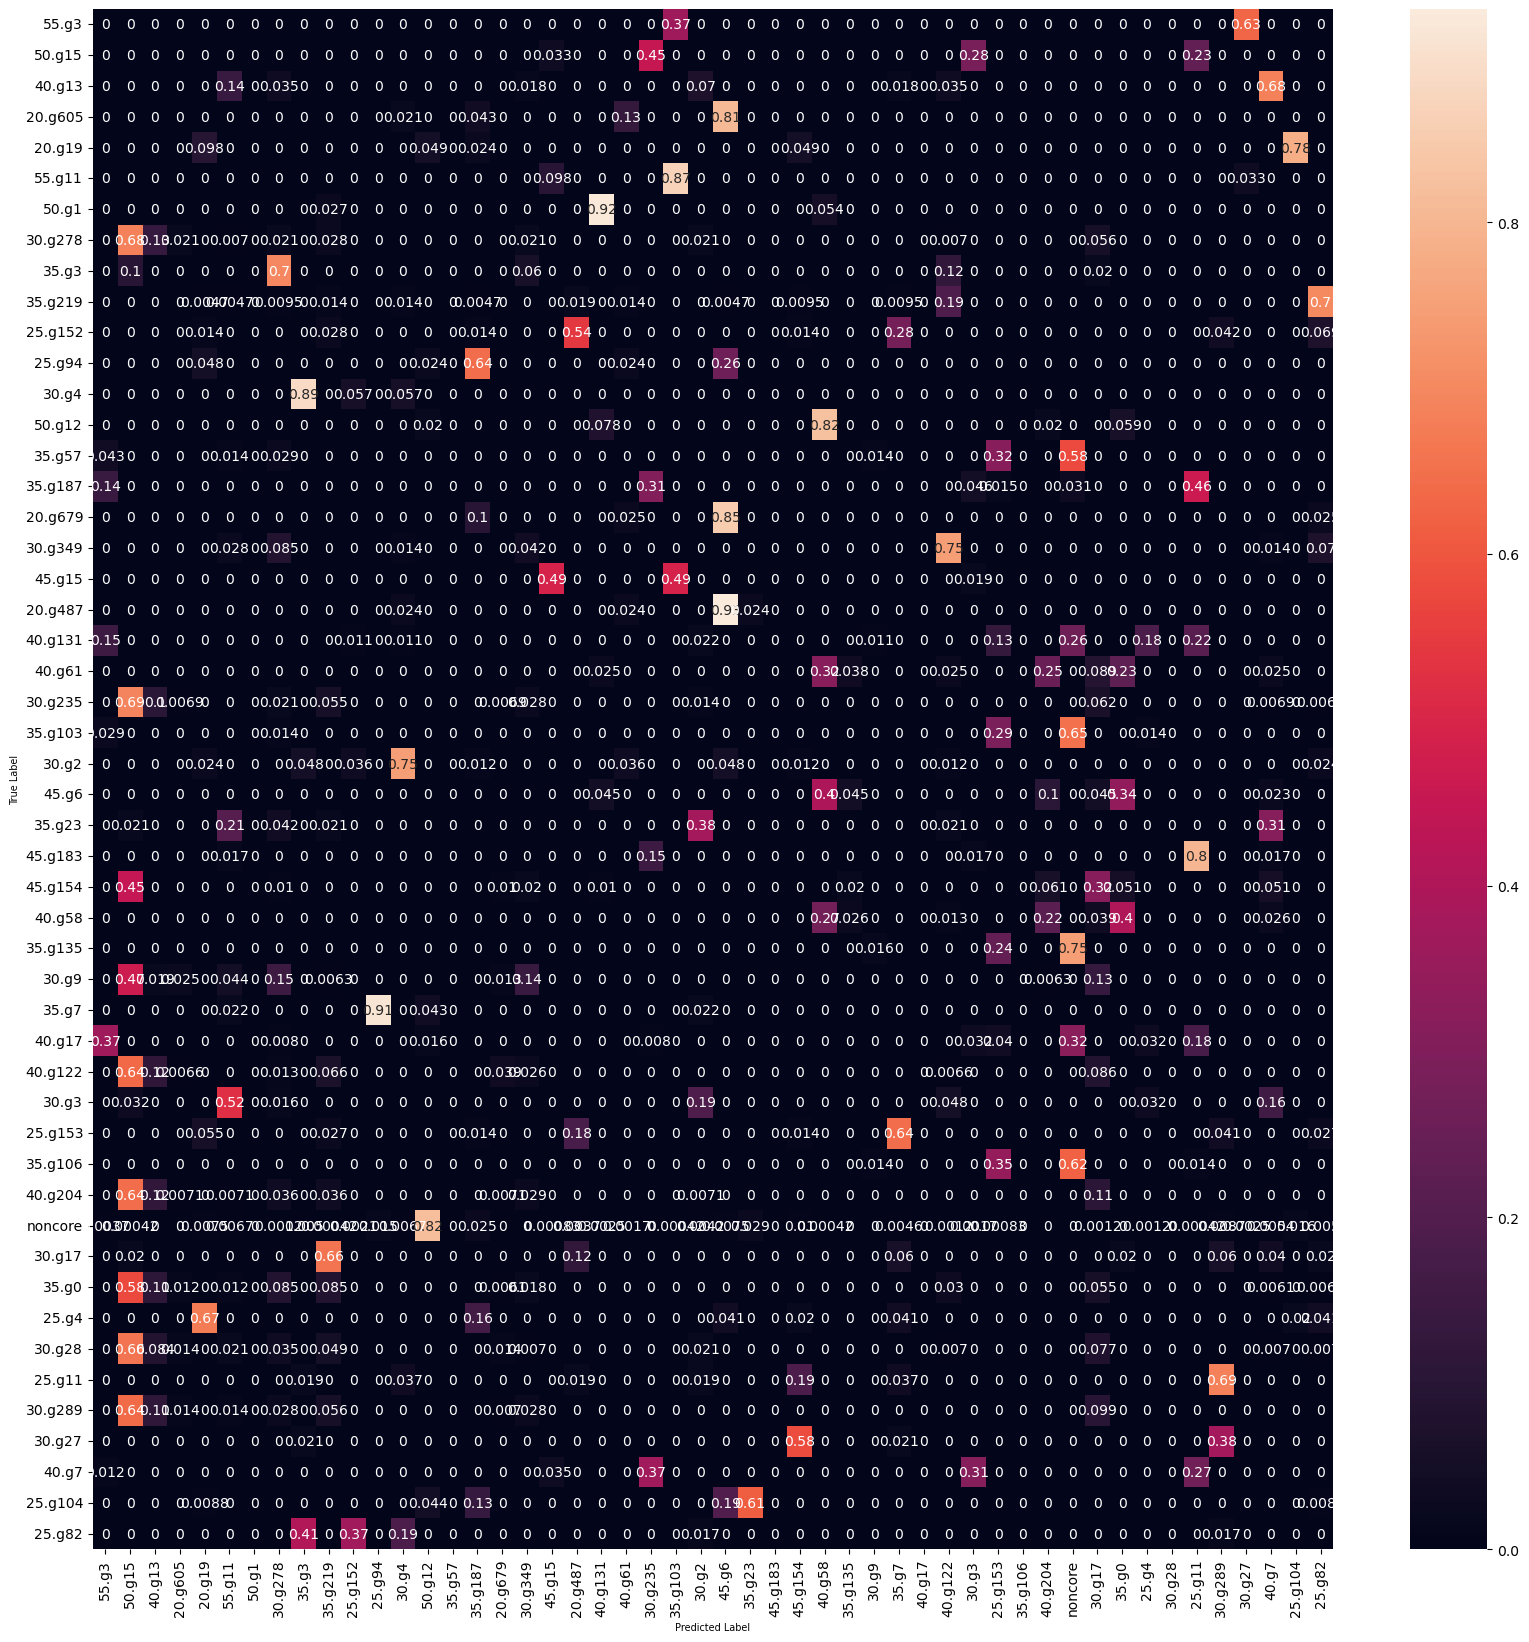

In [33]:
pred_labels = np.argmax(ypred,axis = 1)
true_labels = np.argmax(ytest,axis = 1)

plt.figure(figsize=(20,20))
sns.heatmap(confusion_matrix(true_labels, pred_labels, normalize="true"), annot=True, xticklabels = class_encoding.keys(), yticklabels = class_encoding.keys())
plt.xlabel("Predicted Label", fontsize= 7)
plt.ylabel("True Label", fontsize= 7)

plt.show()

In [29]:
print(classification_report(true_labels, pred_labels, target_names=class_encoding))

              precision    recall  f1-score   support

       55.g3       0.00      0.00      0.00        46
      50.g15       0.00      0.00      0.00        60
      40.g13       0.00      0.00      0.00        57
     20.g605       0.00      0.00      0.00        47
      20.g19       0.06      0.10      0.07        41
      55.g11       0.00      0.00      0.00        61
       50.g1       0.00      0.00      0.00        37
     30.g278       0.03      0.02      0.02       142
       35.g3       0.00      0.00      0.00        50
     35.g219       0.03      0.01      0.02       211
     25.g152       0.00      0.00      0.00        72
      25.g94       0.00      0.00      0.00        42
       30.g4       0.02      0.06      0.03        35
      50.g12       0.00      0.02      0.00        51
      35.g57       0.00      0.00      0.00        69
     35.g187       0.00      0.00      0.00        65
     20.g679       0.00      0.00      0.00        40
     30.g349       0.06    

/home/arnaud/miniconda3/envs/projet_long/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/arnaud/miniconda3/envs/projet_long/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/arnaud/miniconda3/envs/projet_long/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier